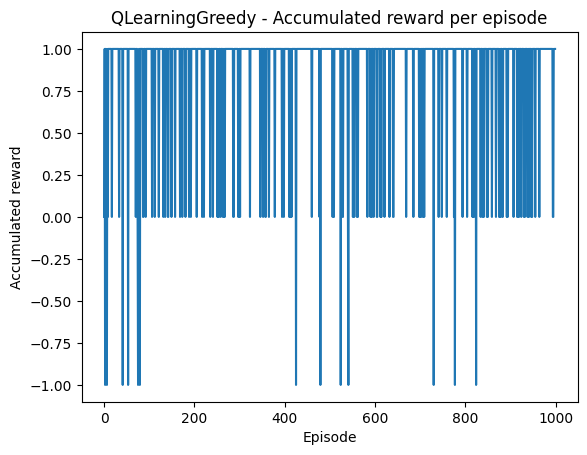

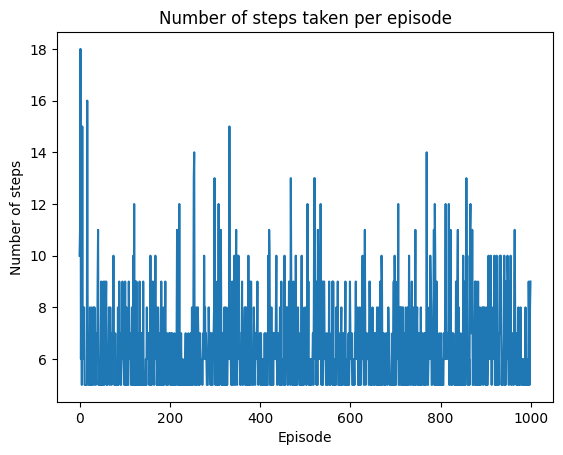

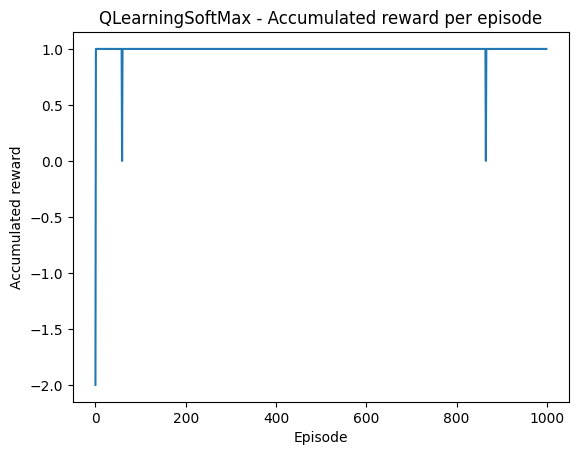

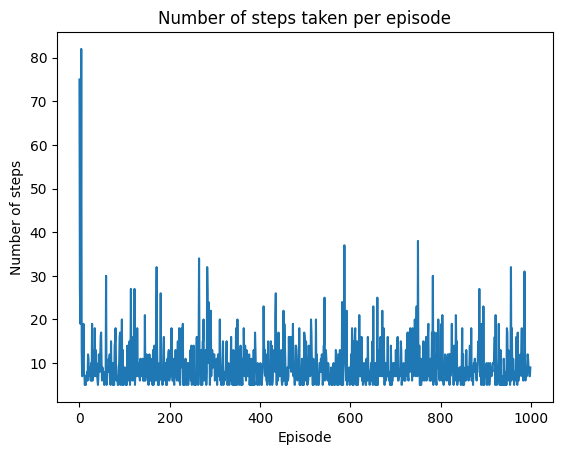

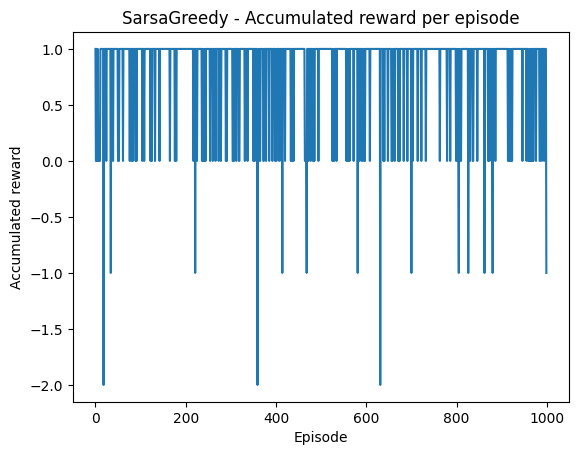

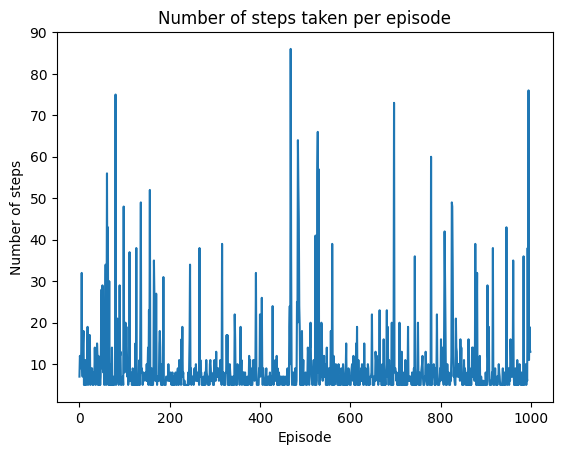

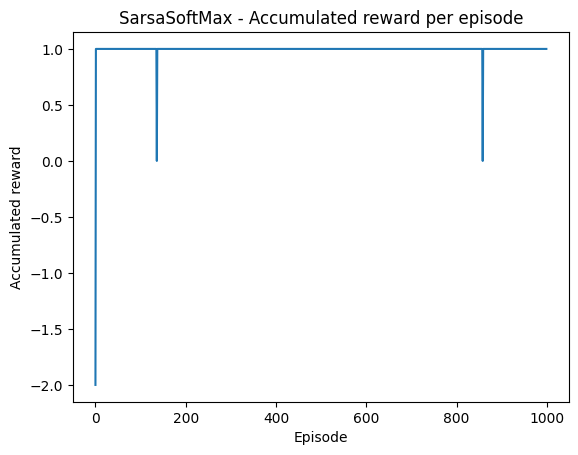

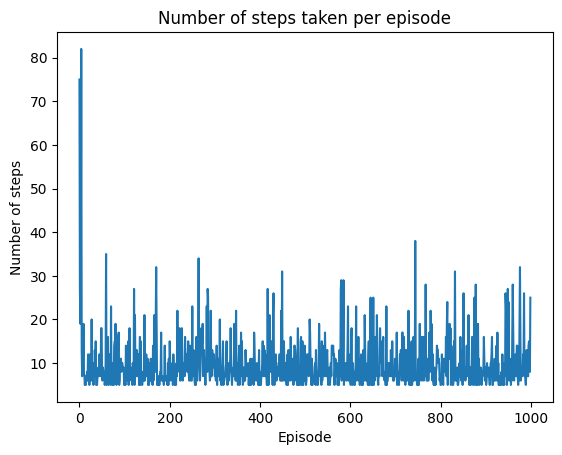

In [1]:
# COMP9414 Assignment 1
# Author: Bowen Zhao
# ZID: z5446616

import numpy as np
import matplotlib.pyplot as plt

class World(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.R = np.zeros(self.x * self.y)
        self.agentPos = 0

    def idx2xy(self, idx):
        x = int(idx / self.y)
        y = idx % self.y
        return x, y

    def xy2idx(self, x, y):
        return x * self.y + y

    def resetAgent(self, pos):
        self.agentPos = int(pos)

    def setReward(self, x, y, r):
        goalState = self.xy2idx(x, y)
        self.R[goalState] = r

    def getState(self):
        return self.agentPos

    def getReward(self):
        return self.R[self.agentPos]

    def getNumOfStates(self):
        return self.x * self.y

    def getNumOfActions(self):
        return 4

    def move(self, id):
        x_, y_ = self.idx2xy(self.agentPos)
        tmpX = x_
        tmpY = y_
        if id == 0:  # move DOWN
            tmpX += 1
        elif id == 1:  # move UP
            tmpX -= 1
        elif id == 2:  # move RIGHT
            tmpY += 1
        elif id == 3:  # move LEFT
            tmpY -= 1
        else:
            print("ERROR: Unknown action")

        if self.validMove(tmpX, tmpY):
            self.agentPos = self.xy2idx(tmpX, tmpY)

    def validMove(self, x, y):
        valid = True
        if x < 0 or x >= self.x:
            valid = False
        if y < 0 or y >= self.y:
            valid = False
        return valid


class QLearningGreedyAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    def actionSelection(self, state):
        rnd = self.random_numbers[self.random_counter]
        self.random_counter += 1
        if rnd <= self.epsilon:
            rnd = self.random_numbers[self.random_counter]
            self.random_counter += 1
            if rnd <= 0.25:
                action = 0
            elif rnd <= 0.5:
                action = 1
            elif rnd <= 0.75:
                action = 2
            else:
                action = 3
        else:
            action = np.argmax(self.Q[state, :])
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []
        steps_per_episode = []

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)
            total_reward = 0
            steps = 0
            expisode = True

            while expisode:
                # choose action
                action = self.actionSelection(state)
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward
                steps += 1  # count steps
                new_state = int(self.world.getState())

                new_action = np.argmax(self.Q[new_state, :])

                # update Q-values using Q-Learning
                self.Q[state, action] += self.alpha * (
                        reward + self.gamma * np.max(self.Q[new_state, :]) - self.Q[
                    state, action])  # use max Q value of new state

                state = new_state

                if reward == 1.0:
                    self.Q[new_state, :] = 0
                    # store the reward of this episode
                    rewards_per_episode.append(total_reward)
                    # store steps count of this episode
                    steps_per_episode.append(steps)
                    expisode = False

        # print(self.Q)

        # plot total rewards and steps per episode
        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("QLearningGreedy - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class QLearningSoftMaxAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.temperature = 0.1  # tau parameter for softmax

    def actionSelection(self, state):
        expQ = np.exp(self.Q[state, :] / self.temperature)
        softmax = expQ / np.sum(expQ)
        cumulative_softmax = np.cumsum(softmax)
        action = np.where(self.random_numbers[self.random_counter] < cumulative_softmax)[0][0]
        self.random_counter += 1
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []  # list to save total reward per episode
        steps_per_episode = []  # list to save total steps per episode

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)

            # choose action
            action = self.actionSelection(state)

            total_reward = 0  # variable to store the total reward for each episode
            total_steps = 0  # variable to store the total steps for each episode

            while True:
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward

                state_new = int(self.world.getState())
                total_steps += 1  # count steps

                # update Q-values using Q-learning method
                self.Q[state, action] += self.alpha * (
                            reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[state, action])

                state = state_new
                action = self.actionSelection(state_new)  # select new action based on new state

                if reward == 1.0:
                    self.Q[state_new, :] = 0
                    break  # end of this episode

            # After each episode, append the total reward and steps to their respective lists
            rewards_per_episode.append(total_reward)
            steps_per_episode.append(total_steps)

        # After all episodes, print and plot the results
        # print(self.Q)

        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("QLearningSoftMax - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class SarsaGreedyAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    # def actionSelection(self, state):
    #     if self.random_numbers[self.random_counter] <= self.epsilon:
    #         action = np.random.randint(self.numOfActions)
    #     else:
    #         action = np.argmax(self.Q[state,:])
    #     self.random_counter += 1
    #     return action

    def actionSelection(self, state):
        rnd = self.random_numbers[self.random_counter]
        self.random_counter += 1
        if rnd <= self.epsilon:
            rnd = self.random_numbers[self.random_counter]
            self.random_counter += 1
            if rnd <= 0.25:
                action = 0
            elif rnd <= 0.5:
                action = 1
            elif rnd <= 0.75:
                action = 2
            else:
                action = 3
        else:
            action = np.argmax(self.Q[state, :])
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        total_rewards = []
        steps_per_episode = []
        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)
            total_reward = 0
            steps = 0

            while True:
                # choose action
                action = self.actionSelection(state)
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                new_state = int(self.world.getState())
                # new action
                new_action = self.actionSelection(new_state)

                # update Q-values using on-policy SARSA
                self.Q[state, action] += self.alpha * (
                            reward + self.gamma * self.Q[new_state, new_action] - self.Q[state, action])

                state = new_state
                action = new_action

                total_reward += reward  # add reward to total reward
                steps += 1  # increment step count

                if reward == 1.0:
                    self.Q[new_state, :] = 0
                    total_rewards.append(total_reward)  # add total reward to list
                    steps_per_episode.append(steps)  # add step count to list
                    break

        # print(self.Q)
        # plot total rewards and steps per episode
        plt.figure()
        plt.plot(total_rewards)
        plt.title("SarsaGreedy - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class SarsaSoftMaxAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.temperature = 0.1  # tau parameter for softmax

    def actionSelection(self, state):
        expQ = np.exp(self.Q[state, :] / self.temperature)
        softmax = expQ / np.sum(expQ)
        cumulative_softmax = np.cumsum(softmax)
        action = np.where(self.random_numbers[self.random_counter] < cumulative_softmax)[0][0]
        self.random_counter += 1
        return action


    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []  # list to save total reward per episode
        steps_per_episode = []  # list to save total steps per episode

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)

            # choose action
            a = self.actionSelection(state)
            expisode = True

            total_reward = 0  # variable to store the total reward for each episode
            total_steps = 0  # variable to store the total steps for each episode

            while expisode:
                # perform action
                self.world.move(a)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward

                state_new = int(self.world.getState())
                total_steps += 1  # count steps

                # new action
                a_new = self.actionSelection(state_new)

                # update Q-values
                self.Q[state, a] += self.alpha * (reward +
                                                  self.gamma * self.Q[state_new, a_new] -
                                                  self.Q[state, a])

                state = state_new
                a = a_new

                if reward == 1.0:
                    self.Q[state_new, :] = 0
                    expisode = False

            # After each episode, append the total reward and steps to their respective lists
            rewards_per_episode.append(total_reward)
            steps_per_episode.append(total_steps)

        # After all episodes, print and plot the results
        # print(self.Q)

        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("SarsaSoftMax - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


world = World(3, 4)
world.setReward(2, 3, 1.0)  # Goal state
world.setReward(1, 1, -1.0)  # Fear region

learner1 = QLearningGreedyAgent(world)
learner2 = QLearningSoftMaxAgent(world)
learner3 = SarsaGreedyAgent(world)
learner4 = SarsaSoftMaxAgent(world)

for learner in (learner1, learner2, learner3, learner4):
    learner.train(1000)
    # learner.plotQValues()

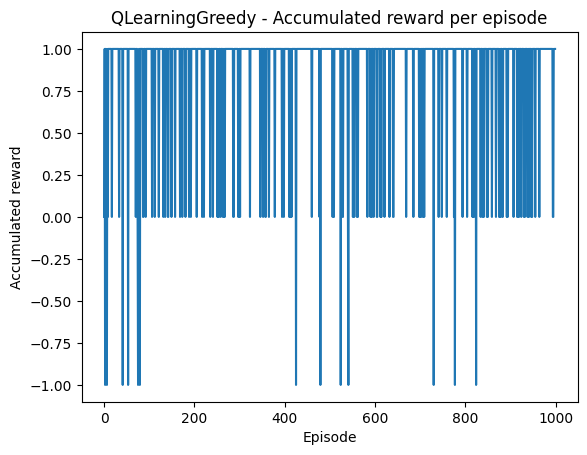

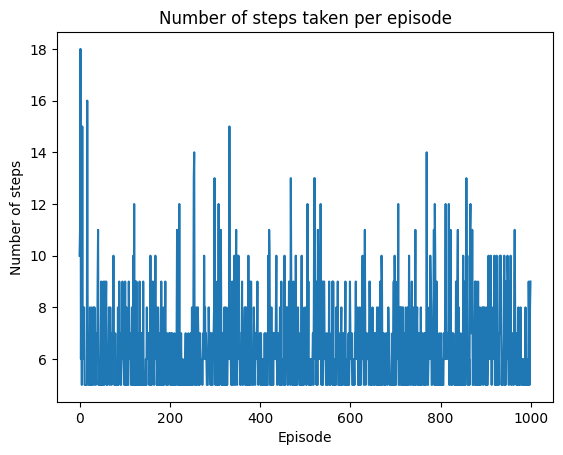

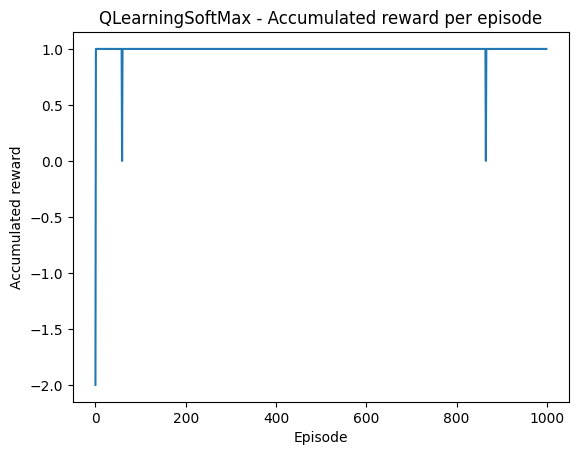

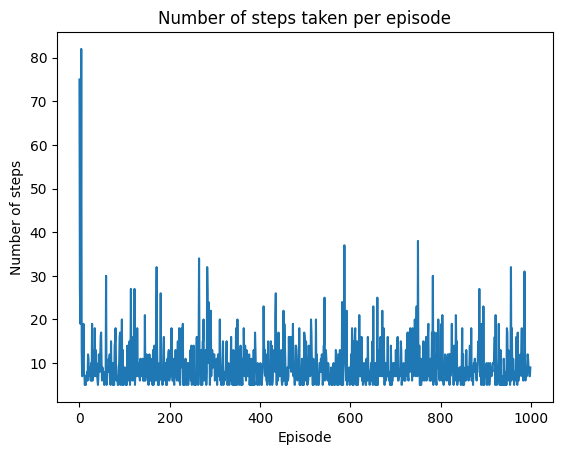

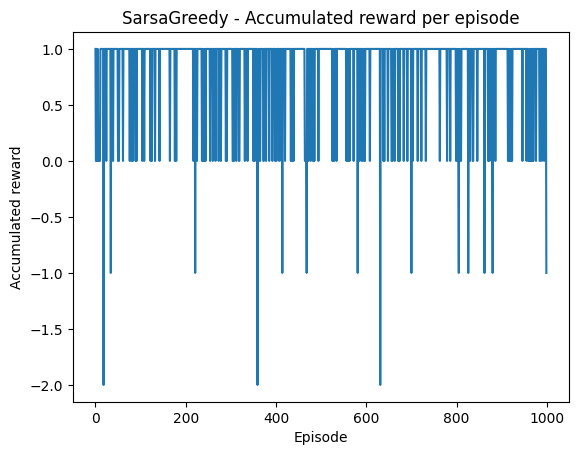

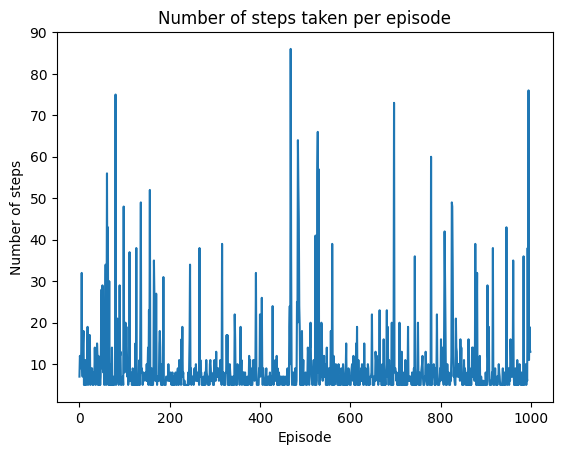

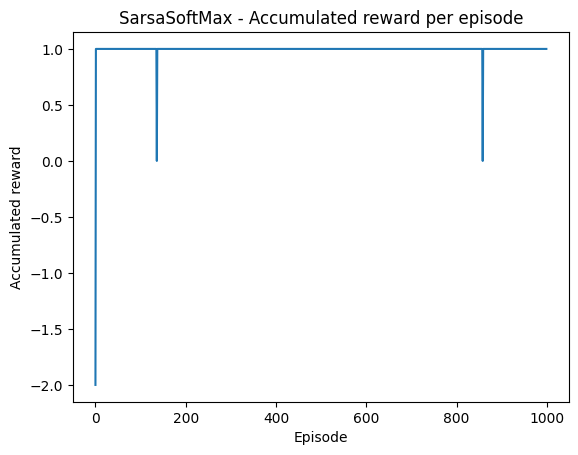

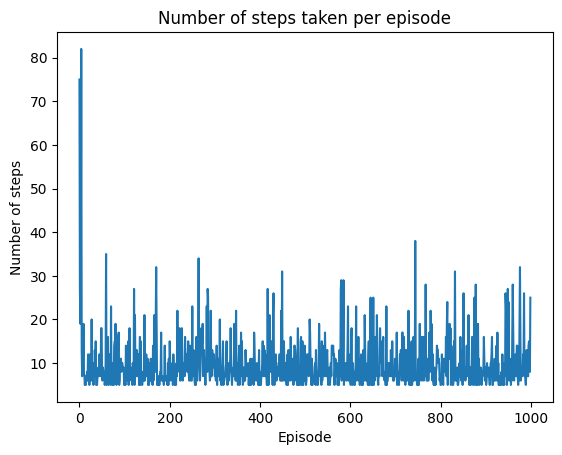

In [ ]:
# COMP9414 Assignment 1
# Author: Bowen Zhao
# ZID: z5446616

import numpy as np
import matplotlib.pyplot as plt

class World(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.R = np.zeros(self.x * self.y)
        self.agentPos = 0

    def idx2xy(self, idx):
        x = int(idx / self.y)
        y = idx % self.y
        return x, y

    def xy2idx(self, x, y):
        return x * self.y + y

    def resetAgent(self, pos):
        self.agentPos = int(pos)

    def setReward(self, x, y, r):
        goalState = self.xy2idx(x, y)
        self.R[goalState] = r

    def getState(self):
        return self.agentPos

    def getReward(self):
        return self.R[self.agentPos]

    def getNumOfStates(self):
        return self.x * self.y

    def getNumOfActions(self):
        return 4

    def move(self, id):
        x_, y_ = self.idx2xy(self.agentPos)
        tmpX = x_
        tmpY = y_
        if id == 0:  # move DOWN
            tmpX += 1
        elif id == 1:  # move UP
            tmpX -= 1
        elif id == 2:  # move RIGHT
            tmpY += 1
        elif id == 3:  # move LEFT
            tmpY -= 1
        else:
            print("ERROR: Unknown action")

        if self.validMove(tmpX, tmpY):
            self.agentPos = self.xy2idx(tmpX, tmpY)

    def validMove(self, x, y):
        valid = True
        if x < 0 or x >= self.x:
            valid = False
        if y < 0 or y >= self.y:
            valid = False
        return valid


class QLearningGreedyAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    def actionSelection(self, state):
        rnd = self.random_numbers[self.random_counter]
        self.random_counter += 1
        if rnd <= self.epsilon:
            rnd = self.random_numbers[self.random_counter]
            self.random_counter += 1
            if rnd <= 0.25:
                action = 0
            elif rnd <= 0.5:
                action = 1
            elif rnd <= 0.75:
                action = 2
            else:
                action = 3
        else:
            action = np.argmax(self.Q[state, :])
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []
        steps_per_episode = []

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)
            total_reward = 0
            steps = 0
            expisode = True

            while expisode:
                # choose action
                action = self.actionSelection(state)
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward
                steps += 1  # count steps
                new_state = int(self.world.getState())

                new_action = np.argmax(self.Q[new_state, :])

                # update Q-values using Q-Learning
                self.Q[state, action] += self.alpha * (
                        reward + self.gamma * np.max(self.Q[new_state, :]) - self.Q[
                    state, action])  # use max Q value of new state

                state = new_state

                if reward == 1.0:
                    self.Q[new_state, :] = 0
                    # store the reward of this episode
                    rewards_per_episode.append(total_reward)
                    # store steps count of this episode
                    steps_per_episode.append(steps)
                    expisode = False

        # print(self.Q)

        # plot total rewards and steps per episode
        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("QLearningGreedy - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class QLearningSoftMaxAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.temperature = 0.1  # tau parameter for softmax

    def actionSelection(self, state):
        expQ = np.exp(self.Q[state, :] / self.temperature)
        softmax = expQ / np.sum(expQ)
        cumulative_softmax = np.cumsum(softmax)
        action = np.where(self.random_numbers[self.random_counter] < cumulative_softmax)[0][0]
        self.random_counter += 1
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []  # list to save total reward per episode
        steps_per_episode = []  # list to save total steps per episode

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)

            # choose action
            action = self.actionSelection(state)

            total_reward = 0  # variable to store the total reward for each episode
            total_steps = 0  # variable to store the total steps for each episode

            while True:
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward

                state_new = int(self.world.getState())
                total_steps += 1  # count steps

                # update Q-values using Q-learning method
                self.Q[state, action] += self.alpha * (
                            reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[state, action])

                state = state_new
                action = self.actionSelection(state_new)  # select new action based on new state

                if reward == 1.0:
                    self.Q[state_new, :] = 0
                    break  # end of this episode

            # After each episode, append the total reward and steps to their respective lists
            rewards_per_episode.append(total_reward)
            steps_per_episode.append(total_steps)

        # After all episodes, print and plot the results
        # print(self.Q)

        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("QLearningSoftMax - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class SarsaGreedyAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

    # def actionSelection(self, state):
    #     if self.random_numbers[self.random_counter] <= self.epsilon:
    #         action = np.random.randint(self.numOfActions)
    #     else:
    #         action = np.argmax(self.Q[state,:])
    #     self.random_counter += 1
    #     return action

    def actionSelection(self, state):
        rnd = self.random_numbers[self.random_counter]
        self.random_counter += 1
        if rnd <= self.epsilon:
            rnd = self.random_numbers[self.random_counter]
            self.random_counter += 1
            if rnd <= 0.25:
                action = 0
            elif rnd <= 0.5:
                action = 1
            elif rnd <= 0.75:
                action = 2
            else:
                action = 3
        else:
            action = np.argmax(self.Q[state, :])
        return action

    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        total_rewards = []
        steps_per_episode = []
        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)
            total_reward = 0
            steps = 0

            while True:
                # choose action
                action = self.actionSelection(state)
                # perform action
                self.world.move(action)
                # look for reward
                reward = self.world.getReward()
                new_state = int(self.world.getState())
                # new action
                new_action = self.actionSelection(new_state)

                # update Q-values using on-policy SARSA
                self.Q[state, action] += self.alpha * (
                            reward + self.gamma * self.Q[new_state, new_action] - self.Q[state, action])

                state = new_state
                action = new_action

                total_reward += reward  # add reward to total reward
                steps += 1  # increment step count

                if reward == 1.0:
                    self.Q[new_state, :] = 0
                    total_rewards.append(total_reward)  # add total reward to list
                    steps_per_episode.append(steps)  # add step count to list
                    break

        # print(self.Q)
        # plot total rewards and steps per episode
        plt.figure()
        plt.plot(total_rewards)
        plt.title("SarsaGreedy - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


class SarsaSoftMaxAgent(object):
    def __init__(self, world):
        self.world = world
        self.numOfActions = self.world.getNumOfActions()
        self.numOfStates = self.world.getNumOfStates()
        self.Q = np.loadtxt('initial_Q_values.txt')
        self.random_numbers = np.loadtxt('random_numbers.txt')
        self.random_counter = 0
        self.alpha = 0.7
        self.gamma = 0.4
        self.temperature = 0.1  # tau parameter for softmax

    def actionSelection(self, state):
        expQ = np.exp(self.Q[state, :] / self.temperature)
        softmax = expQ / np.sum(expQ)
        cumulative_softmax = np.cumsum(softmax)
        action = np.where(self.random_numbers[self.random_counter] < cumulative_softmax)[0][0]
        self.random_counter += 1
        return action


    def plotQValues(self):
        plt.rcParams.update({'font.size': 11})
        plt.imshow(self.Q, cmap='Oranges', interpolation='nearest', aspect='auto')
        plt.colorbar()
        plt.title("Q-values")
        plt.xlabel("Actions")
        plt.ylabel("States")
        plt.xticks(np.arange(4), ('Down', 'Up', 'Right', 'Left'))
        plt.yticks(np.arange(self.numOfStates), np.arange(self.numOfStates))
        plt.show()

    def train(self, iter):
        rewards_per_episode = []  # list to save total reward per episode
        steps_per_episode = []  # list to save total steps per episode

        for itr in range(iter):
            state = 0
            self.world.resetAgent(state)

            # choose action
            a = self.actionSelection(state)
            expisode = True

            total_reward = 0  # variable to store the total reward for each episode
            total_steps = 0  # variable to store the total steps for each episode

            while expisode:
                # perform action
                self.world.move(a)
                # look for reward
                reward = self.world.getReward()
                total_reward += reward  # accumulate reward

                state_new = int(self.world.getState())
                total_steps += 1  # count steps

                # new action
                a_new = self.actionSelection(state_new)

                # update Q-values
                self.Q[state, a] += self.alpha * (reward +
                                                  self.gamma * self.Q[state_new, a_new] -
                                                  self.Q[state, a])

                state = state_new
                a = a_new

                if reward == 1.0:
                    self.Q[state_new, :] = 0
                    expisode = False

            # After each episode, append the total reward and steps to their respective lists
            rewards_per_episode.append(total_reward)
            steps_per_episode.append(total_steps)

        # After all episodes, print and plot the results
        # print(self.Q)

        plt.figure()
        plt.plot(rewards_per_episode)
        plt.title("SarsaSoftMax - Accumulated reward per episode")
        plt.xlabel("Episode")
        plt.ylabel("Accumulated reward")
        plt.show()

        plt.figure()
        plt.plot(steps_per_episode)
        plt.title("Number of steps taken per episode")
        plt.xlabel("Episode")
        plt.ylabel("Number of steps")
        plt.show()


world = World(3, 4)
world.setReward(2, 3, 1.0)  # Goal state
world.setReward(1, 1, -1.0)  # Fear region

learner1 = QLearningGreedyAgent(world)
learner2 = QLearningSoftMaxAgent(world)
learner3 = SarsaGreedyAgent(world)
learner4 = SarsaSoftMaxAgent(world)

for learner in (learner1, learner2, learner3, learner4):
    learner.train(1000)
    # learner.plotQValues()